# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [108]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

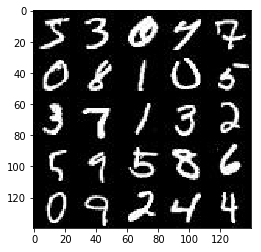

In [109]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot


mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

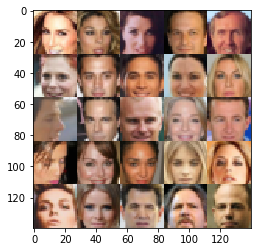

In [110]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [111]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [112]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [120]:
# additional functions

# for debugging - print out the tensor shapes
def tensor_shape(t):
    print('shape: ' + str(t.shape))

# switch for using leaky relu or not
def relu_type(leaky, alpha, t):
        if leaky == 1:
            a = tf.maximum(alpha * t, t)
        else:
            a = tf.nn.relu(t)
        return a
    
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.9
    
    # define sizes - from 28 > 14 > 7 > 4 
    size = 64
    sz_1, sz_2, sz_3 = size*1, size*2, size*4
    
    use_leaky_relu = 1 # switch to use either (1==yes, 0==No)
    
    with tf.variable_scope('discriminator', reuse=reuse) as discrim_scope:
        # create conv net with input images that are 28 x 28 x 3 (channel for the face data)
        # tf.layers.dense([input_image], filter depth, kernel size, strides, padding)
        disc_1 = tf.layers.conv2d(images, sz_1, 5, strides=2, 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                  padding='same')
        relu_1 = tf.nn.dropout(relu_type(use_leaky_relu, alpha, disc_1), keep_prob)
        # output size: 14 x 14 x 64
        
        disc_2 = tf.layers.conv2d(relu_1, sz_2, 5, strides=2,
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                  padding='same')
        bn_2 = tf.layers.batch_normalization(disc_2, training=True)
        relu_2 = tf.nn.dropout(relu_type(use_leaky_relu, alpha, bn_2), keep_prob)
        # output size: 7 x 7 x 128
        
        disc_3 = tf.layers.conv2d(relu_2, sz_3, 5, strides=2,
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                  padding='same')
        bn_3 = tf.layers.batch_normalization(disc_3, training=True)
        relu_3 = tf.nn.dropout(relu_type(use_leaky_relu, alpha, bn_3), keep_prob)
        # output size: 4 x 4 x 256
        
        # flatten the shape
        flat = tf.reshape(relu_3, (-1, 2*2*sz_3))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        # bebug - print shapes
#         tensor_shape(images)
#         tensor_shape(relu_1)
#         tensor_shape(relu_2)
#         tensor_shape(relu_3)
#         tensor_shape(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [121]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.5
    use_leaky_relu = 1 # switch to use either (1==yes, 0==No)
    
    size = 64
    sz_1, sz_2_2, sz_2, sz_3 = size*1, size*2, size*8, size*16
    
    reuse = not is_train # need to set this value from something
    training = is_train # keeps is similar to the lessons to avoid confusion
    
    with tf.variable_scope('generator', reuse=reuse) as gen_scope:
        # this must be the reverse of the discriminator
        gen_1 = tf.layers.dense(z, 4 * 4 * sz_3)
        # reshapre to start conv transpose stack
        gen_1 = tf.reshape(gen_1, (-1, 4, 4, sz_3))
        gen_1 = tf.layers.batch_normalization(gen_1, training=training)
        gen_1 = relu_type(use_leaky_relu, alpha, gen_1)
        # gen_1 = tf.nn.dropout(gen_1, keep_prob)
        # output shape: 4 x 4 x 1024
        
        gen_2 = tf.layers.conv2d_transpose(gen_1, sz_2, 4, strides=1,
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding='valid')
        gen_2 = tf.layers.batch_normalization(gen_2, training=training)
        gen_2 = relu_type(use_leaky_relu, alpha, gen_2)
        # gen_2 = tf.nn.dropout(gen_2, keep_prob)
        # output shape: 7 x 7 x 512
        
#         gen_2_2 = tf.layers.conv2d_transpose(gen_2, sz_2_2, 4, strides=1,
#                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
#                                            padding='same')
#         gen_2_2 = tf.layers.batch_normalization(gen_2_2, training=training)
#         gen_2_2 = relu_type(use_leaky_relu, alpha, gen_2_2)
        # output shape: 7 x 7 x 128
        
        gen_3 = tf.layers.conv2d_transpose(gen_2, sz_1, 4, strides=2,
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding='same')
        gen_3 = tf.layers.batch_normalization(gen_3, training=training)
        gen_3 = tf.nn.dropout(relu_type(use_leaky_relu, alpha, gen_3), keep_prob)
        # gen_3 = relu_type(use_leaky_relu, alpha, gen_3)
        # output size: 14 x 14 x 64  
        
        # output layer
        logits = tf.layers.conv2d_transpose(gen_3, out_channel_dim, 4, strides=2,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                            padding='same')
        # output size: 28 x 28 x out_channel_dim
        
        out = tf.tanh(logits)
        
        
        # bebug - print shapes
#         tensor_shape(z)
#         tensor_shape(gen_1)
#         tensor_shape(gen_2)
# #         tensor_shape(gen_2_2)
#         tensor_shape(gen_3)
#         tensor_shape(logits)
#         print(out_channel_dim)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [122]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth_param = 0.1 # smoothing parameter
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real) * (1-smooth_param)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                        labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                        labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [116]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function    
    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith('disc')]
    g_vars = [v for v in t_vars if v.name.startswith('gen')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # optimize
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#         d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
#         g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [117]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [118]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # tf.reset_default_graph()
    # vars needed 
    # samples, losses = [], []
    losses = []
    count_itters = 0 # to count itterations
    print_every = 10 # print state every itterations
    show_every = 100 # show state every itterations
    fig_size = (5, 5)
    
    # print('data image mode: ' + str(data_image_mode))
    
    # keep var names here the same as the reutrns from the functions for sanity
    # inputs
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    # optimization
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # start the session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # count iterations
                count_itters += 1
                
                # batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
                
                # Sample random noise for the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # batch_z = batch_z.reshape(batch_size, z_dim)
                
                # run optimizers
                # discriminator
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, 
                                                     lr: learning_rate})
                # generator
                for g_runs in range(2):
                    _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images,
                                                         lr: learning_rate})
                
                
                if count_itters % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # save losses for review after training
                    losses.append((train_loss_d, train_loss_g))
                
                if (count_itters % show_every == 0) or count_itters == 1:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
                    
    # plot losses 
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

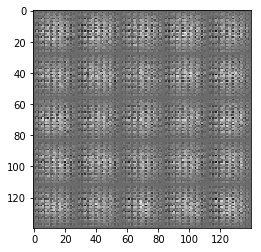

Epoch 1/2... Discriminator Loss: 2.4073... Generator Loss: 0.2317
Epoch 1/2... Discriminator Loss: 1.7191... Generator Loss: 0.4326
Epoch 1/2... Discriminator Loss: 1.5295... Generator Loss: 0.7232
Epoch 1/2... Discriminator Loss: 1.3276... Generator Loss: 1.0835
Epoch 1/2... Discriminator Loss: 1.3306... Generator Loss: 0.8331
Epoch 1/2... Discriminator Loss: 1.3639... Generator Loss: 0.6823
Epoch 1/2... Discriminator Loss: 1.4003... Generator Loss: 0.6326
Epoch 1/2... Discriminator Loss: 1.4885... Generator Loss: 0.6077
Epoch 1/2... Discriminator Loss: 1.4242... Generator Loss: 0.8547
Epoch 1/2... Discriminator Loss: 1.3975... Generator Loss: 0.7486


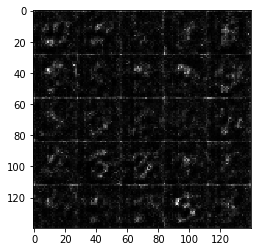

Epoch 1/2... Discriminator Loss: 1.4604... Generator Loss: 0.6404
Epoch 1/2... Discriminator Loss: 1.4484... Generator Loss: 0.6287
Epoch 1/2... Discriminator Loss: 1.4502... Generator Loss: 0.9612
Epoch 1/2... Discriminator Loss: 1.3728... Generator Loss: 0.9285
Epoch 1/2... Discriminator Loss: 1.4721... Generator Loss: 0.6645
Epoch 1/2... Discriminator Loss: 1.5025... Generator Loss: 0.5986
Epoch 1/2... Discriminator Loss: 1.4526... Generator Loss: 1.0834
Epoch 1/2... Discriminator Loss: 1.3707... Generator Loss: 0.8273
Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 0.6784
Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.8699


Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.8598
Epoch 1/2... Discriminator Loss: 1.3725... Generator Loss: 0.7889
Epoch 1/2... Discriminator Loss: 1.3302... Generator Loss: 0.7989
Epoch 1/2... Discriminator Loss: 1.4582... Generator Loss: 0.6944
Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.7616
Epoch 1/2... Discriminator Loss: 1.4157... Generator Loss: 0.6979
Epoch 1/2... Discriminator Loss: 1.4009... Generator Loss: 1.0189
Epoch 1/2... Discriminator Loss: 1.4800... Generator Loss: 0.7105
Epoch 1/2... Discriminator Loss: 1.5393... Generator Loss: 0.4653
Epoch 1/2... Discriminator Loss: 1.3857... Generator Loss: 0.7846


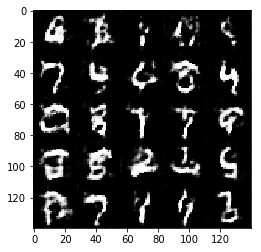

Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 0.8958
Epoch 1/2... Discriminator Loss: 1.4140... Generator Loss: 1.0797
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.7379
Epoch 1/2... Discriminator Loss: 1.4843... Generator Loss: 1.1970
Epoch 1/2... Discriminator Loss: 1.3148... Generator Loss: 0.8209
Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 0.8783
Epoch 1/2... Discriminator Loss: 1.4140... Generator Loss: 0.6163
Epoch 1/2... Discriminator Loss: 1.2939... Generator Loss: 0.8330
Epoch 1/2... Discriminator Loss: 1.6708... Generator Loss: 0.3724
Epoch 1/2... Discriminator Loss: 1.3855... Generator Loss: 0.7503


Epoch 1/2... Discriminator Loss: 1.3354... Generator Loss: 0.8353
Epoch 1/2... Discriminator Loss: 1.5410... Generator Loss: 0.8986
Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 0.7584
Epoch 1/2... Discriminator Loss: 1.3499... Generator Loss: 0.7063
Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 1.1382
Epoch 1/2... Discriminator Loss: 1.3342... Generator Loss: 0.8586
Epoch 1/2... Discriminator Loss: 1.3552... Generator Loss: 0.8340
Epoch 1/2... Discriminator Loss: 1.3842... Generator Loss: 1.0924
Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.8145
Epoch 1/2... Discriminator Loss: 2.0580... Generator Loss: 1.9568


Epoch 1/2... Discriminator Loss: 1.4430... Generator Loss: 0.7601
Epoch 1/2... Discriminator Loss: 1.3846... Generator Loss: 0.7847
Epoch 1/2... Discriminator Loss: 1.3632... Generator Loss: 0.8434
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 1.0567
Epoch 1/2... Discriminator Loss: 1.3368... Generator Loss: 0.8064
Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 0.6531
Epoch 1/2... Discriminator Loss: 1.5078... Generator Loss: 0.6012
Epoch 1/2... Discriminator Loss: 1.4366... Generator Loss: 0.9726
Epoch 1/2... Discriminator Loss: 1.3257... Generator Loss: 0.7999
Epoch 1/2... Discriminator Loss: 1.3633... Generator Loss: 0.5590


Epoch 1/2... Discriminator Loss: 1.4857... Generator Loss: 0.9090
Epoch 1/2... Discriminator Loss: 1.2645... Generator Loss: 0.7081
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 0.7878
Epoch 1/2... Discriminator Loss: 1.3001... Generator Loss: 0.7171
Epoch 1/2... Discriminator Loss: 1.3363... Generator Loss: 0.6736
Epoch 1/2... Discriminator Loss: 1.4001... Generator Loss: 0.6151
Epoch 1/2... Discriminator Loss: 1.3406... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 1.3175... Generator Loss: 0.7630
Epoch 1/2... Discriminator Loss: 1.2902... Generator Loss: 0.8057
Epoch 1/2... Discriminator Loss: 1.4343... Generator Loss: 1.2179


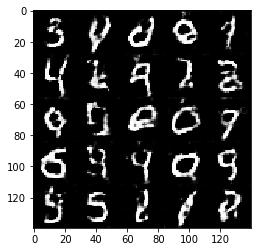

Epoch 1/2... Discriminator Loss: 1.3262... Generator Loss: 0.6718
Epoch 1/2... Discriminator Loss: 1.5173... Generator Loss: 1.2424
Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 0.7243
Epoch 1/2... Discriminator Loss: 1.3269... Generator Loss: 0.7622
Epoch 1/2... Discriminator Loss: 1.3284... Generator Loss: 0.8128
Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 0.6903
Epoch 1/2... Discriminator Loss: 1.2348... Generator Loss: 0.8294
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 0.8176
Epoch 1/2... Discriminator Loss: 1.4518... Generator Loss: 0.5496
Epoch 1/2... Discriminator Loss: 1.3915... Generator Loss: 1.1752


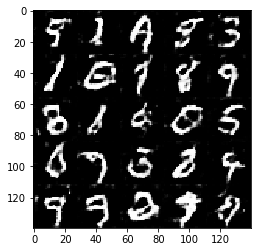

Epoch 1/2... Discriminator Loss: 1.3614... Generator Loss: 1.3099
Epoch 1/2... Discriminator Loss: 1.4727... Generator Loss: 0.4880
Epoch 1/2... Discriminator Loss: 1.4320... Generator Loss: 0.8794
Epoch 1/2... Discriminator Loss: 1.1916... Generator Loss: 1.2349
Epoch 1/2... Discriminator Loss: 1.2294... Generator Loss: 0.9395
Epoch 1/2... Discriminator Loss: 1.2989... Generator Loss: 0.6766
Epoch 1/2... Discriminator Loss: 1.3188... Generator Loss: 0.7539
Epoch 1/2... Discriminator Loss: 1.2005... Generator Loss: 0.8660
Epoch 1/2... Discriminator Loss: 1.3266... Generator Loss: 0.6454
Epoch 1/2... Discriminator Loss: 1.2521... Generator Loss: 0.8661


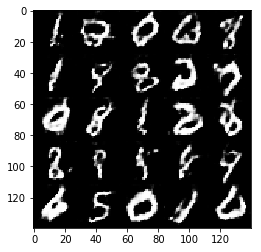

Epoch 1/2... Discriminator Loss: 1.2524... Generator Loss: 0.7100
Epoch 1/2... Discriminator Loss: 1.3880... Generator Loss: 0.7993
Epoch 1/2... Discriminator Loss: 1.3216... Generator Loss: 0.7417
Epoch 2/2... Discriminator Loss: 1.2777... Generator Loss: 0.6897
Epoch 2/2... Discriminator Loss: 1.4604... Generator Loss: 1.2822
Epoch 2/2... Discriminator Loss: 1.3830... Generator Loss: 0.5937
Epoch 2/2... Discriminator Loss: 1.2599... Generator Loss: 0.8427
Epoch 2/2... Discriminator Loss: 1.2553... Generator Loss: 0.7910
Epoch 2/2... Discriminator Loss: 1.5453... Generator Loss: 0.4460
Epoch 2/2... Discriminator Loss: 1.3809... Generator Loss: 0.8416


Epoch 2/2... Discriminator Loss: 1.2413... Generator Loss: 0.8100
Epoch 2/2... Discriminator Loss: 1.2148... Generator Loss: 0.7481
Epoch 2/2... Discriminator Loss: 1.2725... Generator Loss: 0.7392
Epoch 2/2... Discriminator Loss: 1.2605... Generator Loss: 0.9036
Epoch 2/2... Discriminator Loss: 1.2602... Generator Loss: 0.8466
Epoch 2/2... Discriminator Loss: 1.1976... Generator Loss: 0.9636
Epoch 2/2... Discriminator Loss: 1.6292... Generator Loss: 0.4061
Epoch 2/2... Discriminator Loss: 1.4428... Generator Loss: 0.5406
Epoch 2/2... Discriminator Loss: 1.4505... Generator Loss: 0.5532
Epoch 2/2... Discriminator Loss: 1.2306... Generator Loss: 0.6228


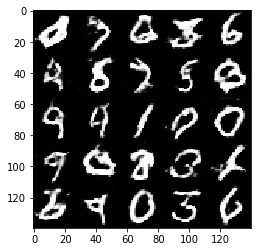

Epoch 2/2... Discriminator Loss: 1.2243... Generator Loss: 0.7577
Epoch 2/2... Discriminator Loss: 1.2266... Generator Loss: 0.9376
Epoch 2/2... Discriminator Loss: 1.2634... Generator Loss: 0.7303
Epoch 2/2... Discriminator Loss: 1.2012... Generator Loss: 0.9183
Epoch 2/2... Discriminator Loss: 1.9115... Generator Loss: 0.2750
Epoch 2/2... Discriminator Loss: 1.3680... Generator Loss: 0.6788
Epoch 2/2... Discriminator Loss: 1.4017... Generator Loss: 0.5812
Epoch 2/2... Discriminator Loss: 1.3148... Generator Loss: 1.4275
Epoch 2/2... Discriminator Loss: 1.5018... Generator Loss: 0.4261
Epoch 2/2... Discriminator Loss: 1.1654... Generator Loss: 0.7187


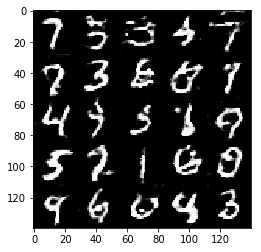

Epoch 2/2... Discriminator Loss: 1.1179... Generator Loss: 0.9576
Epoch 2/2... Discriminator Loss: 1.1834... Generator Loss: 1.3617
Epoch 2/2... Discriminator Loss: 1.2926... Generator Loss: 0.7304
Epoch 2/2... Discriminator Loss: 1.2499... Generator Loss: 1.0384
Epoch 2/2... Discriminator Loss: 1.2292... Generator Loss: 1.1194
Epoch 2/2... Discriminator Loss: 1.2299... Generator Loss: 0.8507
Epoch 2/2... Discriminator Loss: 1.4588... Generator Loss: 0.4897
Epoch 2/2... Discriminator Loss: 1.1277... Generator Loss: 0.9285
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 0.7756
Epoch 2/2... Discriminator Loss: 1.2593... Generator Loss: 1.2797


Epoch 2/2... Discriminator Loss: 1.4609... Generator Loss: 1.6963
Epoch 2/2... Discriminator Loss: 1.2836... Generator Loss: 1.2608
Epoch 2/2... Discriminator Loss: 1.4751... Generator Loss: 0.4584
Epoch 2/2... Discriminator Loss: 1.2983... Generator Loss: 0.6815
Epoch 2/2... Discriminator Loss: 1.2459... Generator Loss: 0.8278
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 1.5025
Epoch 2/2... Discriminator Loss: 1.2545... Generator Loss: 1.4313
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 0.7805
Epoch 2/2... Discriminator Loss: 1.0512... Generator Loss: 1.0091
Epoch 2/2... Discriminator Loss: 1.2681... Generator Loss: 0.9809


Epoch 2/2... Discriminator Loss: 1.3173... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 1.3855... Generator Loss: 1.8217
Epoch 2/2... Discriminator Loss: 1.3637... Generator Loss: 0.6421
Epoch 2/2... Discriminator Loss: 1.0844... Generator Loss: 0.8875
Epoch 2/2... Discriminator Loss: 1.2955... Generator Loss: 0.9775
Epoch 2/2... Discriminator Loss: 1.2847... Generator Loss: 0.6113
Epoch 2/2... Discriminator Loss: 1.2121... Generator Loss: 0.7724
Epoch 2/2... Discriminator Loss: 1.0784... Generator Loss: 0.8983
Epoch 2/2... Discriminator Loss: 1.1052... Generator Loss: 0.8243
Epoch 2/2... Discriminator Loss: 1.0675... Generator Loss: 1.1750


Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 1.0174
Epoch 2/2... Discriminator Loss: 1.2018... Generator Loss: 0.9330
Epoch 2/2... Discriminator Loss: 0.9923... Generator Loss: 1.0064
Epoch 2/2... Discriminator Loss: 1.1729... Generator Loss: 0.9506
Epoch 2/2... Discriminator Loss: 1.1227... Generator Loss: 0.9073
Epoch 2/2... Discriminator Loss: 1.2210... Generator Loss: 1.1078
Epoch 2/2... Discriminator Loss: 1.3641... Generator Loss: 1.7049
Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 1.0821
Epoch 2/2... Discriminator Loss: 1.2649... Generator Loss: 0.8498
Epoch 2/2... Discriminator Loss: 1.2370... Generator Loss: 0.7218


Epoch 2/2... Discriminator Loss: 1.2395... Generator Loss: 1.2435
Epoch 2/2... Discriminator Loss: 1.1529... Generator Loss: 1.0911
Epoch 2/2... Discriminator Loss: 1.0692... Generator Loss: 0.9406
Epoch 2/2... Discriminator Loss: 1.2105... Generator Loss: 0.7624
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 0.8487
Epoch 2/2... Discriminator Loss: 1.1763... Generator Loss: 1.5003
Epoch 2/2... Discriminator Loss: 1.0232... Generator Loss: 1.2364
Epoch 2/2... Discriminator Loss: 0.9639... Generator Loss: 1.0120
Epoch 2/2... Discriminator Loss: 1.0666... Generator Loss: 0.9771
Epoch 2/2... Discriminator Loss: 1.0968... Generator Loss: 1.1324


Epoch 2/2... Discriminator Loss: 1.1588... Generator Loss: 0.8735
Epoch 2/2... Discriminator Loss: 1.2420... Generator Loss: 0.6020
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.8579
Epoch 2/2... Discriminator Loss: 0.9322... Generator Loss: 1.2765
Epoch 2/2... Discriminator Loss: 1.8983... Generator Loss: 2.5802
Epoch 2/2... Discriminator Loss: 0.9858... Generator Loss: 0.9522
Epoch 2/2... Discriminator Loss: 1.1077... Generator Loss: 0.6906
Epoch 2/2... Discriminator Loss: 1.2624... Generator Loss: 0.6667
Epoch 2/2... Discriminator Loss: 1.2078... Generator Loss: 0.6136
Epoch 2/2... Discriminator Loss: 1.5594... Generator Loss: 0.7261


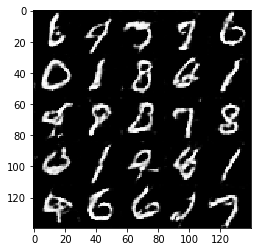

Epoch 2/2... Discriminator Loss: 1.2327... Generator Loss: 0.9482
Epoch 2/2... Discriminator Loss: 1.2170... Generator Loss: 0.8342
Epoch 2/2... Discriminator Loss: 1.1012... Generator Loss: 0.8980
Epoch 2/2... Discriminator Loss: 1.6259... Generator Loss: 0.4062
Epoch 2/2... Discriminator Loss: 1.1936... Generator Loss: 0.9764
Epoch 2/2... Discriminator Loss: 0.9722... Generator Loss: 1.4238
Epoch 2/2... Discriminator Loss: 1.0122... Generator Loss: 1.0271


In [126]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.3495... Generator Loss: 0.3227
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.6361... Generator Loss: 1.5146
Epoch 1/1... Discriminator Loss: 1.6713... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.5896... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 1.5359
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 1.7160
Epoch 1/1... Discriminator Loss: 1.6311... Generator Loss: 1.7597
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 1.0416


Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 1.2326
Epoch 1/1... Discriminator Loss: 1.6173... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.5919... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.6832... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7312


Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.5208... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.7528


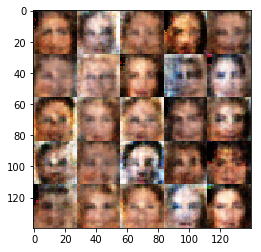

Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.8100


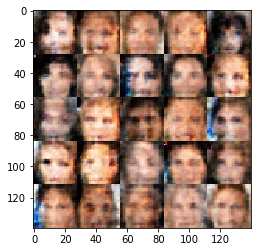

Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7992


Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.8225


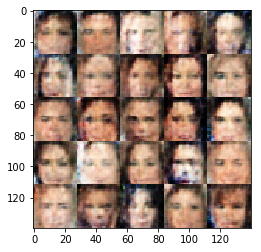

Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7518


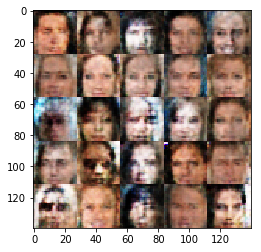

Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7784


Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7782


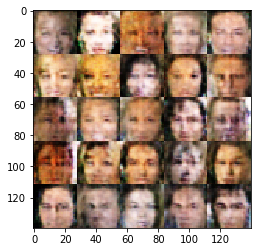

Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7828


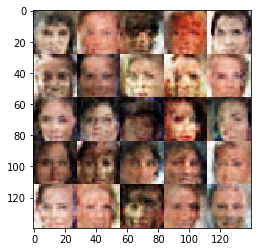

Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7663


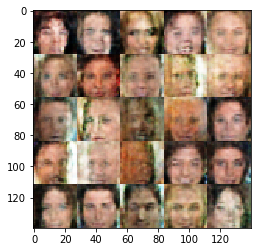

Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7554


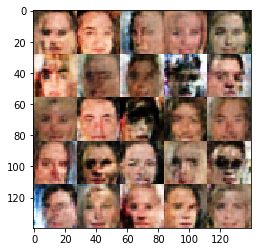

Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.8174


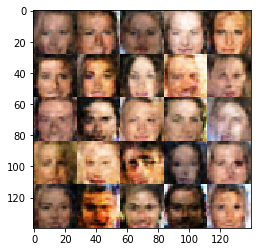

Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.8009


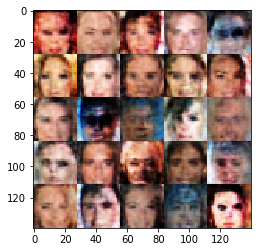

Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7564


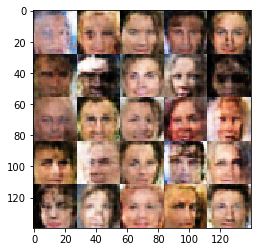

Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7793


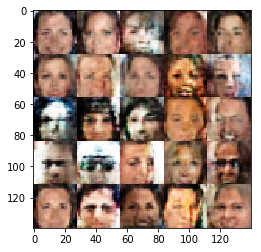

Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7947


Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7952


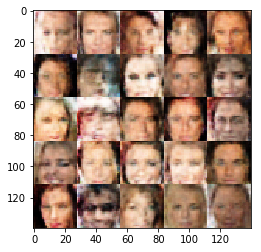

Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7936


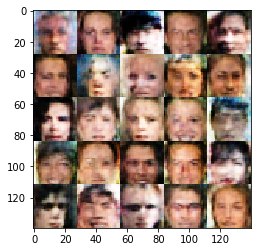

Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.8163


Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7876


Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.8075


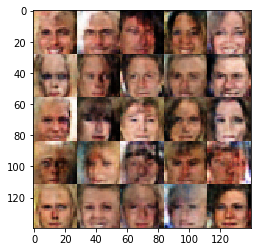

Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.8461


Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.8005


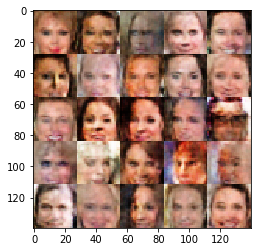

Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7353


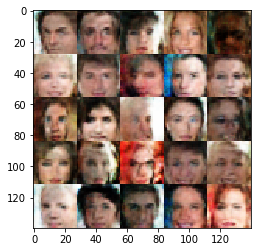

Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7612


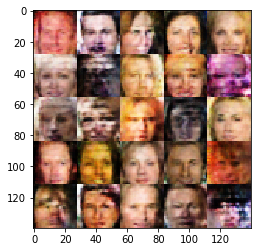

Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.7910


Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7959


Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.8061


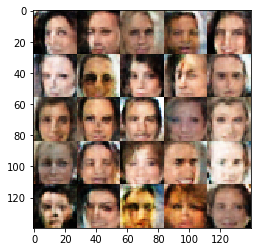

Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7240


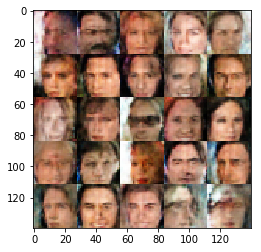

Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7706


Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7081


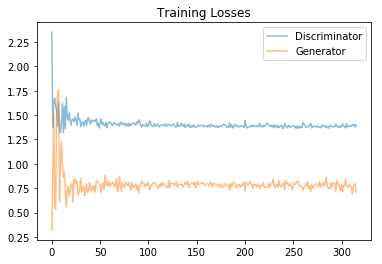

In [127]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.